# 1d Wave Equation on unbounded domain with piecewise velocity, solved by PINN
---

## Direct Problem
Consider the 1d wave equation
$$
\frac{\partial^2 u}{\partial t^2} - \frac{\partial}{\partial x}\left(c(x)^2\frac{\partial u}{\partial x}\right) = 0,
$$
with IC
$$
u(x, 0) = g(x), \frac{\partial u}{\partial t}(x, 0) = 0,
$$

The initial condition is a gaussian shock
$$
g(x) = \left\{
\begin{aligned}
&\frac{1}{2}\exp(-400(x-0.25)^2), &\quad x \in [0.1, 0.4], \\[0.3cm]
&0, &\quad \text{others}.
\end{aligned}
\right.
$$

The spatial domain for this problem is $[0, 1]$. However, the wave is allowed to propagate freely across the boundaries without any constraints, through which a boundless wave propagation is mimicked.

## Inverse Problem

Consider a piecewise wave velocity field
$$
c(x) = \left\{
\begin{aligned}
&0.5, &x \le 0.6, \\
&0.8, &0.6 < x < 0.9, \\
&0.4, &x \ge 0.9 \\
\end{aligned}
\right.
$$
Given a solution trajectory (possibly with noise)
$$
\{u(x, t_1), u(x, t_2), \cdots, u(x, t_m)\}, \quad x = (x_1, x_2, \cdots, x_n),
$$
we want to recover the spatial distribution of the velocity field $c = c(x)$.

## Structure
Direct model:
$$
\Phi_d: (x, t) \to (u(x, t), v(x, t)).
$$
Inverse model:
$$
\Phi_i: (x, t, \Phi_d(x, t)) \to c(x)
$$
Loss:
$$
\mathcal{L} = \mathcal{L}_r(x, t) + \mathcal{L}_{i}(x, t) + \mathcal{L}_f(x, t),
$$
where $\mathcal{L}_r, \mathcal{L}_i, \mathcal{L}_f$ represents for the loss of equation residue, initial condition, and numerical solution.

## Real data
We use a finite difference numerical solver to get the real data for training. In order to minic the unbounded domain, We expand the spatial domain to [-5, 5], and extract the splution on $x\in [0, 1]$ as the real data for training.

## Requirements:
- python >= 3.6
- tensorflow >= 2.0

In [42]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from utils_1d import *
from utils import *
import time

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")
# tf.config.set_visible_devices([], 'GPU')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specify the profiles of the 1d wave problem

In [43]:
np.random.seed(1)

domain = [0.0, 1.0] # domain for the problem
domain_num = [-5.0, 5.0] # domain for finite difference solver
T_max = 1.0

domain_gaussian_pulse = [0.1, 0.5] # domain for Gaussian pulse (of initial condition)
velocity_interface = [0.6, 0.9] # interface of the step velocity field
velocity_field = [0.5, 0.8, 0.4]

# initial condition profile
func_ic = lambda x: np.piecewise(x,
                                [x >= domain_gaussian_pulse[1], (x >= domain_gaussian_pulse[0]) & (x < domain_gaussian_pulse[1]), x < domain_gaussian_pulse[0]],
                                [0,
                                lambda y: 1/2*np.exp(-400*(y-sum(domain_gaussian_pulse)/2)**2),
                                0])
# velocity field profile
func_c = lambda x: np.piecewise(x,
							   [x <= velocity_interface[0], (x > velocity_interface[0]) & (x < velocity_interface[1]), x >= velocity_interface[1]],
							   velocity_field)


## Define the direct model and inverse model

In [44]:
direct_model = keras.models.Sequential([
    keras.layers.Dense(32, input_shape = (2, ),  # (x, t)
                       activation = "tanh"),
    keras.layers.Dense(32,
                      activation = "tanh"),
    keras.layers.Dense(1) # (u)
])

inverse_model = keras.models.Sequential([
    keras.layers.Dense(32, input_shape = (3, ), # (x, t, u)
                       activation = "tanh"),
    keras.layers.Dense(32,
                      activation = "tanh"),
    keras.layers.Dense(1,
					  activation = 'softplus') # (c)
])

## Define the loss function and training step

In [45]:
loss_func = keras.losses.MeanSquaredError()

def get_residue_loss(tape, x, t, u, c):
	du_dx = tape.gradient(u, x)
	du_dxx = tape.gradient(du_dx, x)
	c2du_dx = tf.square(c)*du_dx
	dc2du_dxx = tape.gradient(c2du_dx, x)
	
	du_dt = tape.gradient(u, t)
	du_dtt = tape.gradient(du_dt, t)
	return loss_func(du_dtt, dc2du_dxx)

def get_initial_loss(tape, x, t, u, c, u_true):
	initial_residue_loss = get_residue_loss(tape, x, t, u, c)
	du_dt = tape.gradient(u, t)
	initial_func_loss = loss_func(u, u_true) + loss_func(du_dt, tf.zeros_like(du_dt))
	return initial_residue_loss, initial_func_loss

def get_num_loss(tape, x, t, u, c, u_true):
	num_residue_loss = get_residue_loss(tape, x, t, u, c)
	num_func_loss = loss_func(u, u_true)
	return num_residue_loss, num_func_loss

@tf.function
def forward(x, t):
	u = direct_model(tf.concat([x, t], axis = 1))
	c = inverse_model(tf.concat([x, t, u], axis = 1))
	return u, c

@cast_to_tf_constant(tf.float32)
def train_step(x_collocation, t_collocation, 
               x_ic, t_ic, u_ic_true,
			   x_num, t_num, u_num_true):
	
	with tf.GradientTape(persistent = True) as tape:
		tape.watch(x_collocation)
		tape.watch(t_collocation)
		tape.watch(x_ic)
		tape.watch(t_ic)
		tape.watch(x_num)
		tape.watch(t_num)
				
		u_collocation, c_collocation = forward(x_collocation, t_collocation)
		u_ic, c_ic = forward(x_ic, t_ic)
		u_num, c_num = forward(x_num, t_num)
		
		collocation_loss = get_residue_loss(tape, x_collocation, t_collocation, u_collocation, c_collocation)
		ic_residue_loss, ic_func_loss = get_initial_loss(tape, x_ic, t_ic, u_ic, c_ic, u_ic_true)
		num_residue_loss, num_func_loss = get_num_loss(tape, x_num, t_num, u_num, c_num, u_num_true)
		
		loss = collocation_loss + ic_residue_loss + ic_func_loss + num_residue_loss + num_func_loss
    
	grads = tape.gradient(loss, direct_model.trainable_variables + inverse_model.trainable_variables)
	optimizer.apply_gradients(zip(grads, direct_model.trainable_variables + inverse_model.trainable_variables))
	del tape
	
	return loss, {
		"collocation": collocation_loss,
		"ic_residue": ic_residue_loss,
		"ic_func": ic_func_loss,
		"solution_residue": num_residue_loss,
		"solution": num_func_loss
	}

## Generate training points for collocation and initial condition (i.e., unlabelled data)

In [46]:
n_domain = 5000
n_ic = 200
    
x_collocation = transform(np.random.random((n_domain, 1)), *domain).reshape((-1, 1))
t_collocation = transform(np.random.random((n_domain, 1)), 0, T_max).reshape((-1, 1))
x_ic = transform(np.random.random((n_ic, 1)), *domain).reshape((-1, 1))
t_ic = np.zeros_like(x_ic)

func_ic = lambda x: np.piecewise(x, 
                                [x >= domain_gaussian_pulse[1], (x >= domain_gaussian_pulse[0]) & (x < domain_gaussian_pulse[1]), x < domain_gaussian_pulse[0]],
                                [0,
                                lambda y: 1/2*np.exp(-400*(y-sum(domain_gaussian_pulse)/2)**2),
                                0])

u_ic_true = func_ic(x_ic.flatten()).reshape((-1, 1))

## Generate numerical solution for inverse problem

In [50]:
dx_num = 0.001
dt_num = 0.0001
u_num, x_num, t_num = numerical_solver_PML(I = func_ic,
                                          V = lambda x: np.zeros_like(x),
                                          f = lambda x, t: np.zeros_like(x),
                                          c = func_c,
                                          L1 = domain_num[0],
                                          L2 = domain_num[1],
                                          dx = dx_num,
                                          T = T_max,
                                          dt = dt_num,
                                          cmax = 1.0,)
                                          
index_domain = cut(x_num, domain)[0]
x_num = x_num[index_domain]
u_num = u_num[:, index_domain]
print("spatial mesh size:", x_num.shape)
print("temporal mesh size:", t_num.shape)

x_sample_rate = 5
t_sample_rate = 500

x_num_sampled = x_num[::x_sample_rate]
t_num_sampled = t_num[::t_sample_rate]
xt_num_train = tensor_grid([t_num_sampled, x_num_sampled])
xt_num_train[:, [0, 1]] = xt_num_train[:, [1, 0]]
x_num_train, t_num_train = xt_num_train[:, 0:1], xt_num_train[:, 1:2]

u_num_train = u_num[::t_sample_rate, ::x_sample_rate]
u_num_train_1d = u_num_train.reshape((-1, 1))

print("size of spatial data:", x_num_sampled.shape)
print("size of temporal data:", t_num_sampled.shape)
print("size of numerical data:", u_num_train_1d.shape)

Courant Number: 0.1
spatial mesh size: (1001,)
temporal mesh size: (10001,)
size of spatial data: (201,)
size of temporal data: (21,)
size of numerical data: (4221, 1)


## plot numerical data

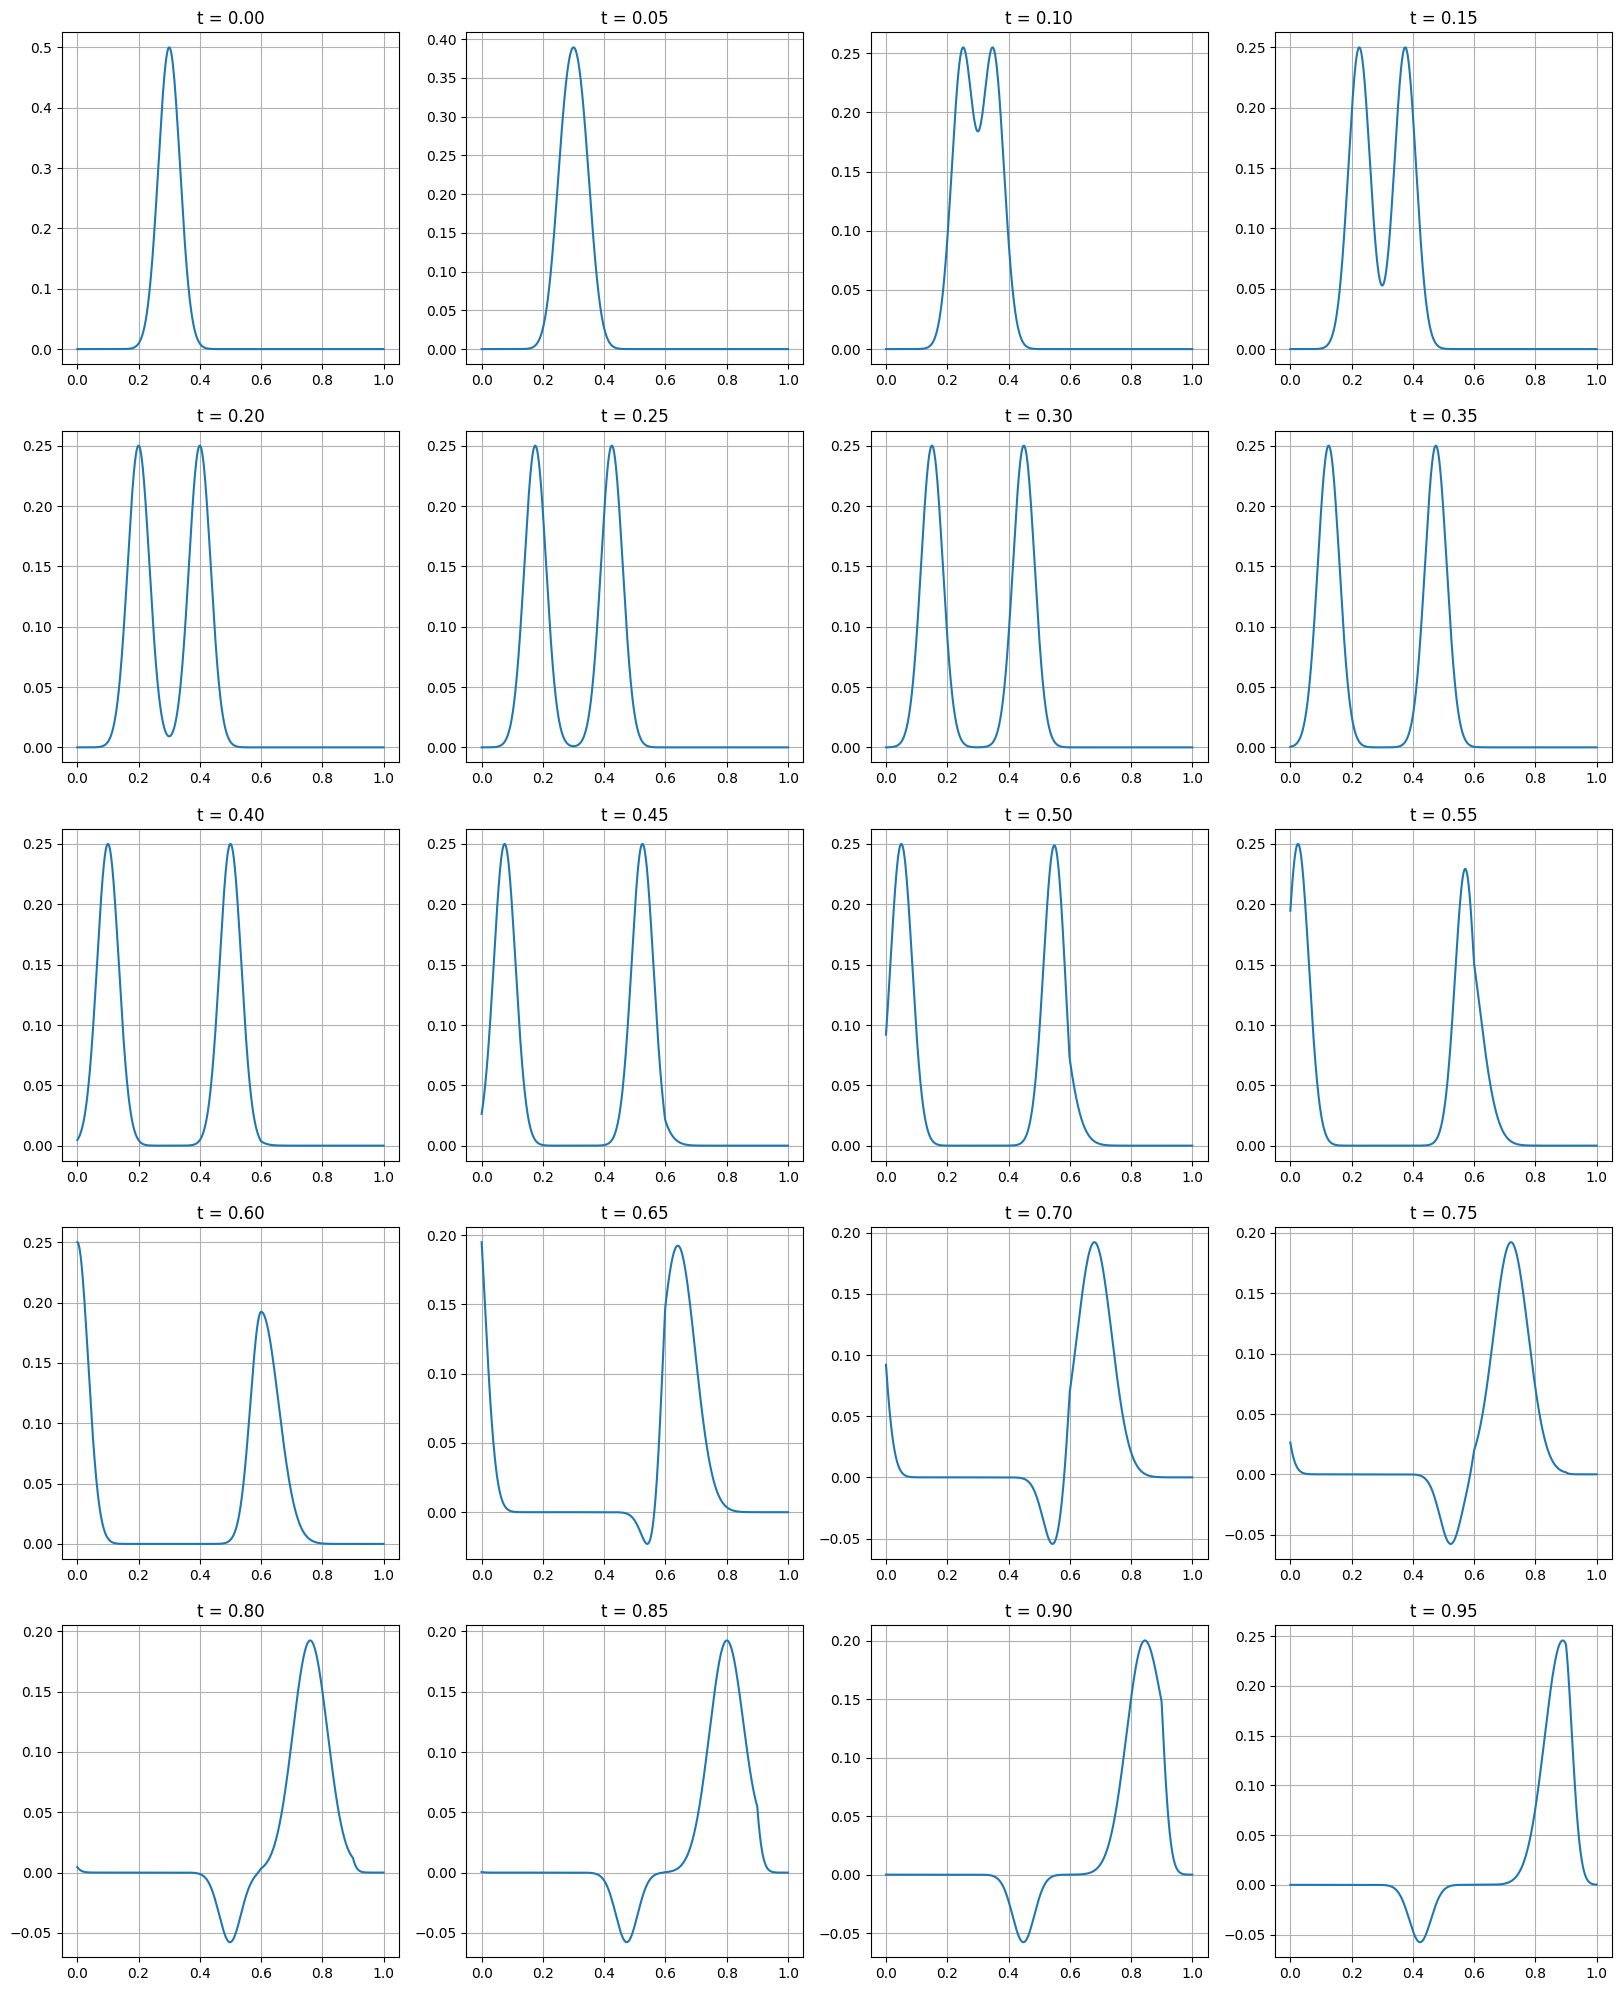

In [51]:
print_every = int(T_max / dt_num)//20

f, ax = plt.subplots(5, 4, figsize = (20, 25))
for i in range(20):
    ax[i // 4][i % 4].plot(x_num, np.squeeze(u_num[i*print_every, :]))
    ax[i // 4][i % 4].set_title("t = {0:.2f}".format(t_num[i*print_every]))
    ax[i // 4][i % 4].grid()
plt.show()

## training

In [ ]:
optimizer = keras.optimizers.Adam(lr = 0.1)

for epoch in range(5000):
    loss, loss_dict = train_step(x_collocation, t_collocation,
								 x_ic, t_ic, u_ic_true,
								 x_num_train, t_num_train, u_num_train_1d)
    if epoch % 100 == 0:
        print("{}, Epoch: {}, Loss: {:.4e}, collocation: {:.4e}, ic: {:.4e}, ic residue: {:.4e}, solution: {:.4e}, solution residue: {:.4e}".format( 
					time.strftime("%D, %H:%M:%S", time.localtime()), epoch, 
					loss.numpy(), loss_dict["collocation"].numpy(), loss_dict["ic_func"].numpy(), loss_dict["ic_residue"].numpy(), 
					loss_dict["solution"].numpy(), loss_dict["solution_residue"].numpy()))

04/05/20, 21:46:19, Epoch: 0, Loss: 3.7219e-01, collocation: 1.1827e-03, ic: 1.8078e-01, ic residue: 1.9662e-03, solution: 1.8703e-01, solution residue: 1.2335e-03
